<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/bwang_merah_ukuran_sedang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fef41cc5c90>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.bawang_merah_ukuran_sedang.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


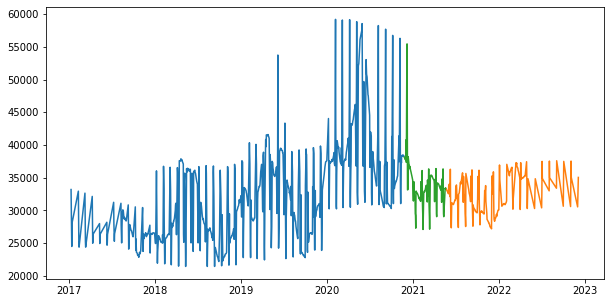

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 16s 65ms/step - loss: 0.2266 - mae: 0.4379 - mape: 92.0414 - val_loss: 0.0240 - val_mae: 0.1429 - val_mape: 60.9668
Epoch 2/30
44/44 [==============================] - 1s 28ms/step - loss: 0.1584 - mae: 0.3505 - mape: 70.5734 - val_loss: 0.0086 - val_mae: 0.0850 - val_mape: 41.5507
Epoch 3/30
44/44 [==============================] - 1s 26ms/step - loss: 0.1131 - mae: 0.2792 - mape: 53.1839 - val_loss: 0.0038 - val_mae: 0.0482 - val_mape: 32.8150
Epoch 4/30
44/44 [==============================] - 1s 26ms/step - loss: 0.0849 - mae: 0.2260 - mape: 40.6487 - val_loss: 0.0051 - val_mae: 0.0487 - val_mape: 39.6516
Epoch 5/30
44/44 [==============================] - 1s 24ms/step - loss: 0.0667 - mae: 0.1933 - mape: 34.6441 - val_loss: 0.0094 - val_mae: 0.0788 - val_mape: 57.4490
Epoch 6/30
44/44 [==============================] - 1s 28ms/step - loss: 0.0548 - mae: 0.1713 - mape: 31.2766 - val_loss: 0.0144 - val_mae: 0.1043 - val_mape: 71.77

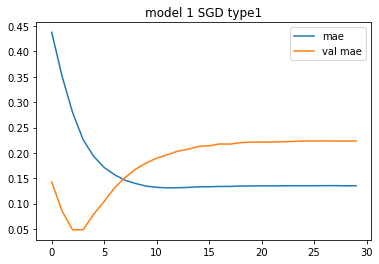

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_beras_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 2s 8ms/step
6029.089 19.499699 6613.422412034483


,date,actual,prediction
0,2021-05-20,33350,38950.695312
1,2021-05-21,33350,38980.011719
2,2021-05-24,33100,38976.636719
3,2021-05-25,33000,38988.000000
4,2021-05-27,32900,38986.394531
...,...,...,...
229,2022-11-02,34300,38594.101562
230,2022-11-03,37550,38681.625000
231,2022-11-04,35050,38587.101562
232,2022-12-01,30550,38673.015625


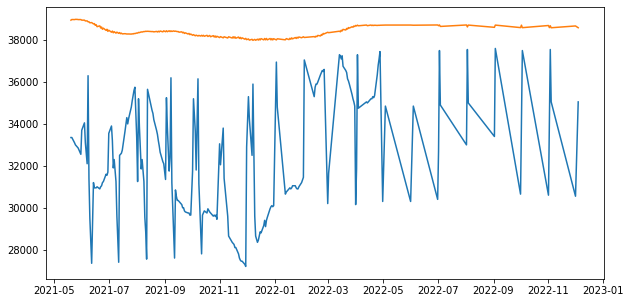

In [ ]:
prediction = forecast_predict(model, test_beras_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras = pd.DataFrame()
data_new_beras['date'] = y_test
data_new_beras['actual'] = x_test
data_new_beras['prediction'] = data_result
data_new_beras.to_csv('bawang_merah_ukuran_sedang_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras.date, data_new_beras.actual)
plt.plot(data_new_beras.date, data_new_beras.prediction)
data_new_beras

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0336 - mae: 0.1457 - mape: 1280389.7500 - val_loss: 0.0269 - val_mae: 0.1523 - val_mape: 97.6654
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0296 - mae: 0.1368 - mape: 1184799.0000 - val_loss: 0.0272 - val_mae: 0.1532 - val_mape: 98.1900
Epoch 3/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0289 - mae: 0.1341 - mape: 1203163.7500 - val_loss: 0.0296 - val_mae: 0.1608 - val_mape: 102.2551
Epoch 4/30
718/718 [==============================] - 9s 12ms/step - loss: 0.0285 - mae: 0.1335 - mape: 1367184.7500 - val_loss: 0.0267 - val_mae: 0.1515 - val_mape: 97.2765
Epoch 5/30
718/718 [==============================] - 8s 11ms/step - loss: 0.0277 - mae: 0.1329 - mape: 1278832.3750 - val_loss: 0.0268 - val_mae: 0.1519 - val_mape: 97.4635
Epoch 6/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0275 - mae: 0.1326 - mape: 1286292.0000 - val_loss: 0.0

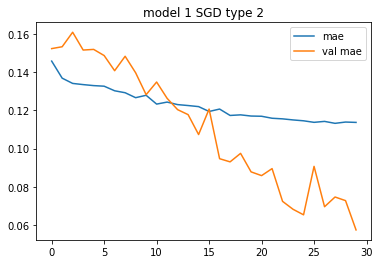

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2510.1697 7.9953136 2992.484085170713


,date,actual,prediction
0,2021-05-20,33350,38950.695312
1,2021-05-21,33350,38980.011719
2,2021-05-24,33100,38976.636719
3,2021-05-25,33000,38988.000000
4,2021-05-27,32900,38986.394531
...,...,...,...
229,2022-11-02,34300,38594.101562
230,2022-11-03,37550,38681.625000
231,2022-11-04,35050,38587.101562
232,2022-12-01,30550,38673.015625


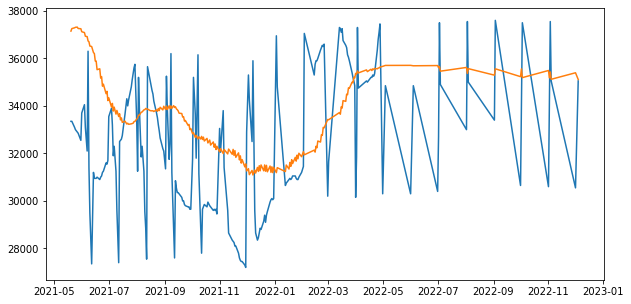

In [ ]:
win_size1 = 60
test_beras_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_1 = pd.DataFrame()
data_new_beras_1['actual'] = x_test
data_new_beras_1['prediction'] = data_result_1
data_new_beras_1.to_csv('bawang_merah_ukuran_sedang_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_1.actual)
plt.plot(y_test, data_new_beras_1.prediction)
data_new_beras

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0259 - mae: 0.1236 - mape: 59.0545 - val_loss: 0.0066 - val_mae: 0.0603 - val_mape: 46.8544
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0259 - mae: 0.1238 - mape: 60.5636 - val_loss: 0.0066 - val_mae: 0.0607 - val_mape: 47.0741
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0259 - mae: 0.1236 - mape: 58.7493 - val_loss: 0.0064 - val_mae: 0.0590 - val_mape: 45.9747
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0259 - mae: 0.1238 - mape: 60.2404 - val_loss: 0.0066 - val_mae: 0.0602 - val_mape: 46.7647
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0258 - mae: 0.1237 - mape: 59.4496 - val_loss: 0.0063 - val_mae: 0.0583 - val_mape: 45.5678
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0259 - mae: 0.1236 - mape: 59.4404 - val_loss: 0.0065 - val_mae: 0.0598 - val_mape: 46.514

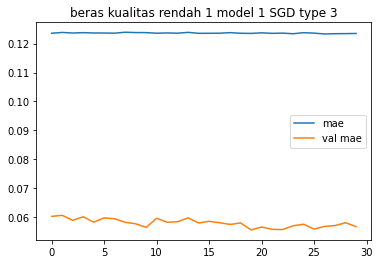

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2521.8967 8.027329 3018.8502778375746


,actual,prediction
0,33350,37351.457031
1,33350,37463.398438
2,33100,37497.125000
3,33000,37520.617188
4,32900,37526.257812
...,...,...
229,34300,35336.394531
230,37550,35587.000000
231,35050,35273.976562
232,30550,35550.308594


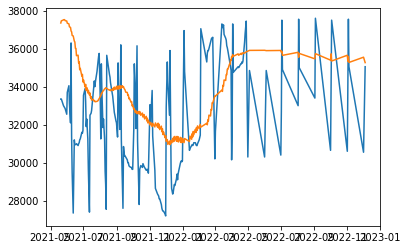

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_2['actual'] = x_test
data_new_beras_2['prediction'] = data_result_2
data_new_beras_2.to_csv('bawang_merah_ukuran_sedang_model1_sgd_type3.csv')

plt.plot(y_test, data_new_beras_2.actual)
plt.plot(y_test, data_new_beras_2.prediction)
data_new_beras_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 5s 39ms/step - loss: 0.2660 - mae: 0.4784 - mape: 101.5332 - val_loss: 0.0400 - val_mae: 0.1903 - val_mape: 85.8029
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.2039 - mae: 0.4099 - mape: 85.0124 - val_loss: 0.0233 - val_mae: 0.1407 - val_mape: 60.0480
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1295 - mae: 0.3033 - mape: 58.9182 - val_loss: 0.0050 - val_mae: 0.0622 - val_mape: 35.7963
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0483 - mae: 0.1642 - mape: 33.7057 - val_loss: 0.0142 - val_mae: 0.1028 - val_mape: 71.1002
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0323 - mae: 0.1365 - mape: 33.1182 - val_loss: 0.0106 - val_mae: 0.0851 - val_mape: 61.1625
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0326 - mae: 0.1345 - mape: 31.0437 - val_loss: 0.0137 - val_mae: 0.1006 - val_mape: 69.87

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a = forecast_predict(model_a, test_beras_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_a = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a['actual'] = x_test
data_new_beras_a['prediction'] = data_result_a
data_new_beras_a.to_csv('bawang_merah_ukuran_sedang_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_a.actual)
plt.plot(y_test, data_new_beras_a.prediction)
data_new_beras_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0219 - mae: 0.1165 - mape: 1003661.6250 - val_loss: 0.0100 - val_mae: 0.0821 - val_mape: 59.5137
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0209 - mae: 0.1129 - mape: 985603.7500 - val_loss: 0.0115 - val_mae: 0.0901 - val_mape: 64.0111
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0208 - mae: 0.1116 - mape: 950446.2500 - val_loss: 0.0073 - val_mae: 0.0648 - val_mape: 49.7300
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0205 - mae: 0.1108 - mape: 934943.3750 - val_loss: 0.0099 - val_mae: 0.0810 - val_mape: 58.9528
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0204 - mae: 0.1084 - mape: 1006373.1875 - val_loss: 0.0049 - val_mae: 0.0477 - val_mape: 38.8782
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0203 - mae: 0.1091 - mape: 956040.1250 - val_loss: 0.0069 - va

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a1 = forecast_predict(model_a, test_beras_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_a1 = pd.DataFrame()
data_new_beras_a1['actual'] = x_test
data_new_beras_a1['prediction'] = data_result_a1
data_new_beras_a1.to_csv('bawang_merah_ukuran_sedang_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_a1.actual)
plt.plot(y_test, data_new_beras_a1.prediction)
data_new_beras_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30


In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a2 = forecast_predict(model_a, test_beras_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_a2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a2['actual'] = x_test
data_new_beras_a2['prediction'] = data_result_a2
data_new_beras_a2.to_csv('bawang_merah_ukuran_sedang_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_a2.actual)
plt.plot(y_test, data_new_beras_a2.prediction)
data_new_beras_a2

## model 1

### Adam

In [36]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [37]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 42ms/step - loss: 0.0578 - mae: 0.1790 - mape: 39.4916 - val_loss: 0.0180 - val_mae: 0.1195 - val_mape: 80.1678
Epoch 2/100
44/44 [==============================] - 1s 21ms/step - loss: 0.0370 - mae: 0.1423 - mape: 32.4184 - val_loss: 0.0298 - val_mae: 0.1613 - val_mape: 102.5543
Epoch 3/100
44/44 [==============================] - 1s 21ms/step - loss: 0.0326 - mae: 0.1344 - mape: 31.2358 - val_loss: 0.0512 - val_mae: 0.2178 - val_mape: 132.7890
Epoch 4/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0327 - mae: 0.1359 - mape: 32.2186 - val_loss: 0.0139 - val_mae: 0.1017 - val_mape: 70.3856
Epoch 5/100
44/44 [==============================] - 1s 23ms/step - loss: 0.0355 - mae: 0.1401 - mape: 32.8611 - val_loss: 0.0117 - val_mae: 0.0914 - val_mape: 64.5642
Epoch 6/100
44/44 [==============================] - 1s 22ms/step - loss: 0.0358 - mae: 0.1417 - mape: 32.7041 - val_loss: 0.0300 - val_mae: 0.1620 - val_mape

17/17 [==============================] - 0s 7ms/step - loss: 0.1259 - mae: 0.2995 - mape: 49.6595


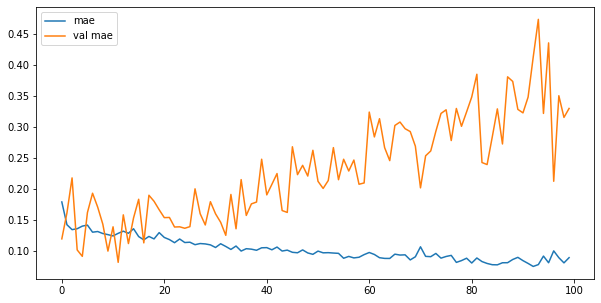

In [38]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [39]:
prediction1 = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras1 = pd.DataFrame()
data_new_beras1['actual'] = x_test
data_new_beras1['prediction'] = data_result1
data_new_beras1.to_csv('bawang_merah_ukuran_sedang_model2_adam_type1.csv')

data_new_beras1

131/131 [==============================] - 2s 7ms/step
8378.755 26.945066 9573.875286423989


,actual,prediction
0,33350,39352.828125
1,33350,39746.960938
2,33100,39847.277344
3,33000,41116.746094
4,32900,41078.820312
...,...,...
229,34300,43311.109375
230,37550,43526.281250
231,35050,43456.218750
232,30550,42526.992188


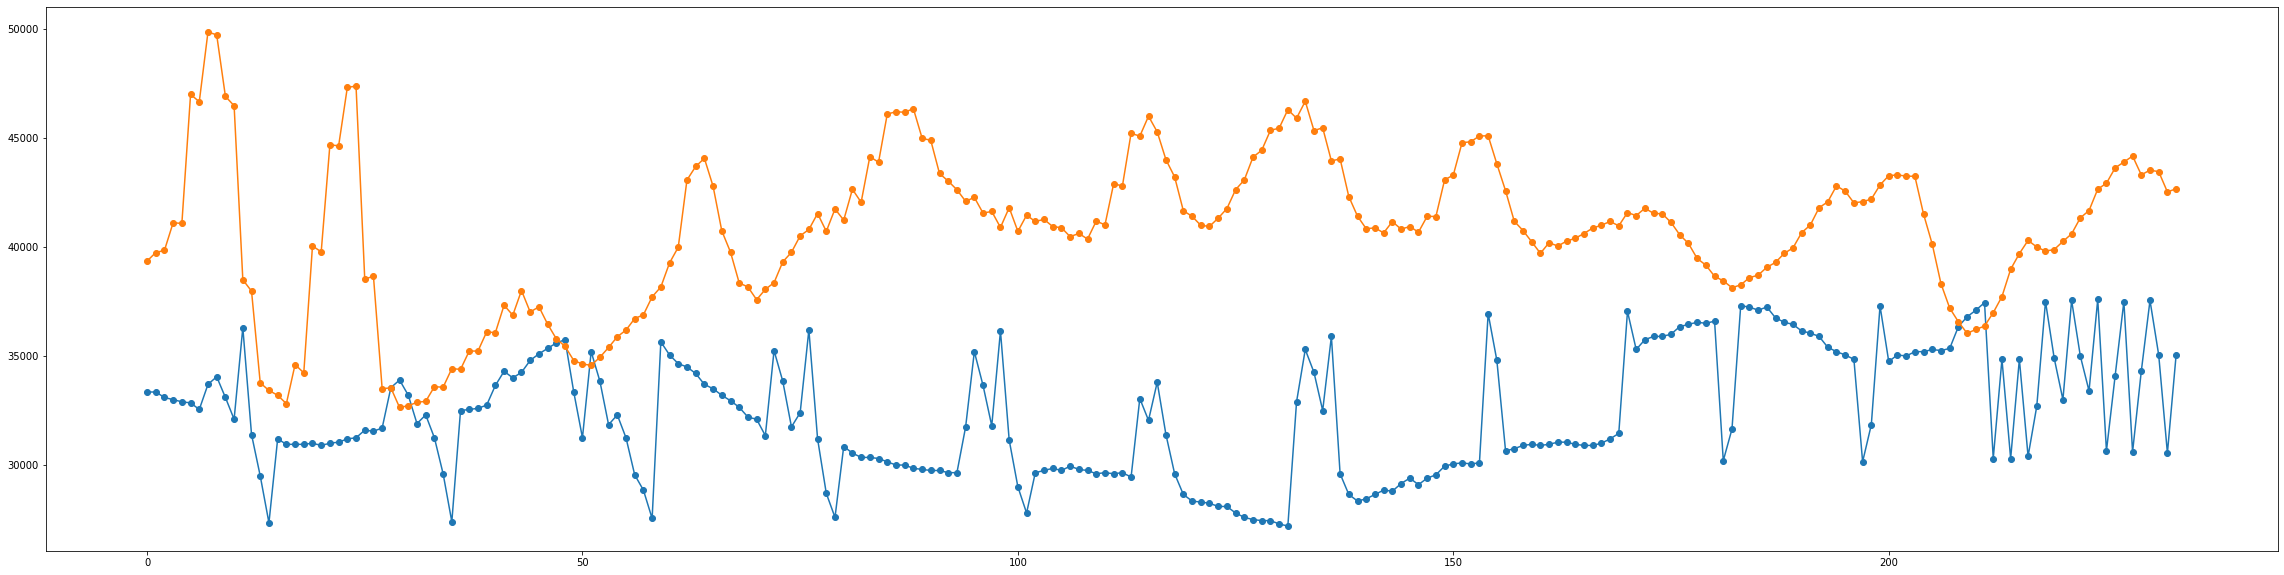

In [40]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras1['prediction'], '-o')

#### Type 2

In [41]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0230 - mae: 0.1156 - mape: 922031.5000 - val_loss: 0.0500 - val_mae: 0.2140 - val_mape: 128.8228
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0217 - mae: 0.1126 - mape: 844344.7500 - val_loss: 0.0089 - val_mae: 0.0772 - val_mape: 54.7107
Epoch 3/15
718/718 [==============================] - 10s 15ms/step - loss: 0.0195 - mae: 0.1063 - mape: 913525.8125 - val_loss: 0.0165 - val_mae: 0.1110 - val_mape: 71.9644
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0196 - mae: 0.1071 - mape: 942138.0000 - val_loss: 0.0665 - val_mae: 0.2505 - val_mape: 150.2483
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0286 - mae: 0.1327 - mape: 974215.9375 - val_loss: 0.0541 - val_mae: 0.2245 - val_mape: 136.3130
Epoch 6/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0272 - mae: 0.1280 - mape: 889570.7500 - val_loss: 0.0390 

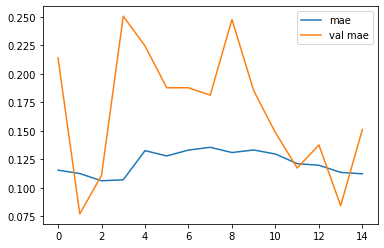

In [42]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
4976.3345 15.990017 9573.875286423989


,actual,prediction
0,33350,40908.492188
1,33350,40898.281250
2,33100,40570.457031
3,33000,40222.085938
4,32900,40000.609375
...,...,...
229,34300,39325.796875
230,37550,38783.675781
231,35050,38329.835938
232,30550,39334.726562


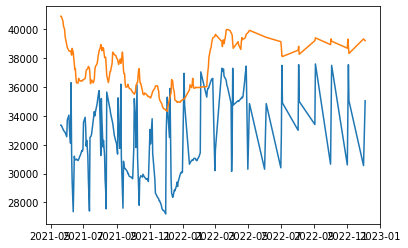

In [43]:
prediction1_1 = forecast_predict(model1, test_beras_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras1_1 = pd.DataFrame()
data_new_beras1_1['actual'] = x_test
data_new_beras1_1['prediction'] = data_result1_1
data_new_beras1_1.to_csv('bawang_merah_ukuran_sedang_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras1_1.actual)
plt.plot(y_test, data_new_beras1_1.prediction)
data_new_beras1_1

#### Type 3

In [44]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 27ms/step - loss: 0.0274 - mae: 0.1245 - mape: 64.4015 - val_loss: 0.0065 - val_mae: 0.0587 - val_mape: 46.0012
Epoch 2/15
84/84 [==============================] - 2s 23ms/step - loss: 0.0250 - mae: 0.1165 - mape: 55.3872 - val_loss: 0.0046 - val_mae: 0.0454 - val_mape: 37.0164
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0245 - mae: 0.1134 - mape: 54.3209 - val_loss: 0.0055 - val_mae: 0.0515 - val_mape: 41.6048
Epoch 4/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0239 - mae: 0.1138 - mape: 54.3901 - val_loss: 0.0044 - val_mae: 0.0448 - val_mape: 36.0777
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0235 - mae: 0.1110 - mape: 53.2961 - val_loss: 0.0041 - val_mae: 0.0469 - val_mape: 34.3949
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0238 - mae: 0.1120 - mape: 53.8901 - val_loss: 0.0045 - val_mae: 0.0438 - val_mape: 35.997

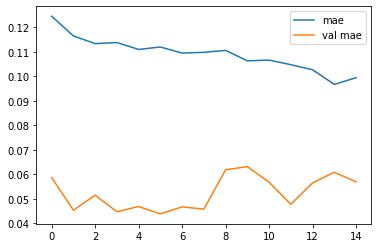

In [45]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
2370.3955 7.463915 9573.875286423989


,actual,prediction
0,33350,39522.339844
1,33350,40412.949219
2,33100,39394.554688
3,33000,39228.960938
4,32900,38843.468750
...,...,...
229,34300,37115.914062
230,37550,35602.699219
231,35050,35446.480469
232,30550,36789.769531


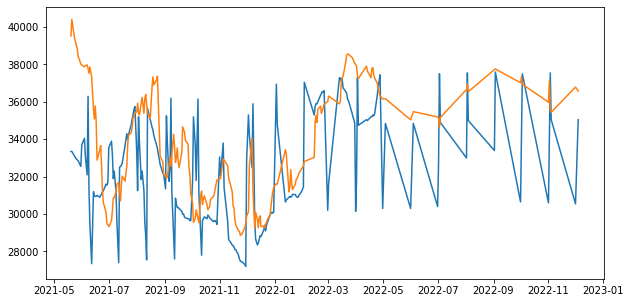

In [46]:
prediction1_2 = forecast_predict(model1, test_beras_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras1_2 = pd.DataFrame()
data_new_beras1_2['actual'] = x_test
data_new_beras1_2['prediction'] = data_result1_2
data_new_beras1_2.to_csv('bawang_merah_ukuran_sedang_model2_adam_type3.csv')
plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_2.actual)
plt.plot(y_test, data_new_beras1_2.prediction)

data_new_beras1_2

### SGD

In [47]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [48]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [49]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 43ms/step - loss: 0.2186 - mae: 0.4279 - mape: 89.5397 - val_loss: 0.0273 - val_mae: 0.1537 - val_mape: 66.1546
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1711 - mae: 0.3689 - mape: 75.1623 - val_loss: 0.0156 - val_mae: 0.1159 - val_mape: 51.4532
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1372 - mae: 0.3198 - mape: 63.2042 - val_loss: 0.0088 - val_mae: 0.0863 - val_mape: 41.9864
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1123 - mae: 0.2782 - mape: 53.0725 - val_loss: 0.0051 - val_mae: 0.0636 - val_mape: 36.0824
Epoch 5/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0931 - mae: 0.2429 - mape: 44.6069 - val_loss: 0.0038 - val_mae: 0.0468 - val_mape: 32.6087
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0784 - mae: 0.2145 - mape: 38.2403 - val_loss: 0.0041 - val_mae: 0.0425 - val_mape: 34.552

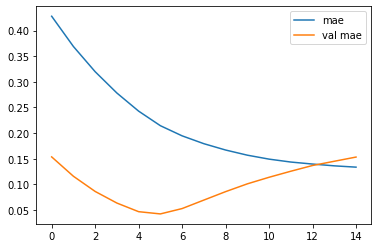

In [50]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 1s 9ms/step
2370.3997 7.4638596 3073.6392110981405


,actual,prediction
0,33350,39526.417969
1,33350,40415.074219
2,33100,39395.472656
3,33000,39229.285156
4,32900,38843.574219
...,...,...
229,34300,37113.960938
230,37550,35597.816406
231,35050,35441.675781
232,30550,36785.800781


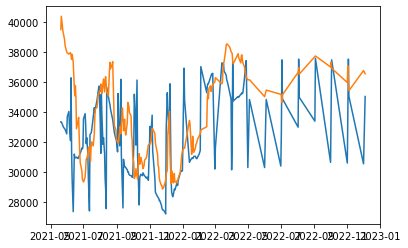

In [52]:
prediction1_a = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras1_a = pd.DataFrame()
data_new_beras1_a['actual'] = x_test
data_new_beras1_a['prediction'] = data_result1_a
data_new_beras1_a.to_csv('bawang_merah_ukuran_sedang_model2_sgd_type1.csv')

plt.plot(y_test, data_new_beras1_a.actual)
plt.plot(y_test, data_new_beras1_a.prediction)

data_new_beras1_a

#### Type 2


In [53]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0297 - mae: 0.1360 - mape: 1280651.0000 - val_loss: 0.0192 - val_mae: 0.1244 - val_mape: 82.7586
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0277 - mae: 0.1323 - mape: 1185600.7500 - val_loss: 0.0175 - val_mae: 0.1173 - val_mape: 78.9989
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0270 - mae: 0.1306 - mape: 1237700.2500 - val_loss: 0.0179 - val_mae: 0.1188 - val_mape: 79.8157
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0266 - mae: 0.1300 - mape: 1271395.2500 - val_loss: 0.0167 - val_mae: 0.1137 - val_mape: 77.0634
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0259 - mae: 0.1278 - mape: 1281324.2500 - val_loss: 0.0166 - val_mae: 0.1134 - val_mape: 76.8936
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0256 - mae: 0.1271 - mape: 1279881.7500 - val_loss: 0.0148 

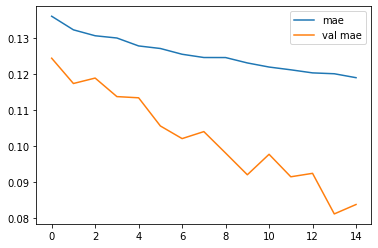

In [54]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2756.7979 8.898743 3223.6381620771276


,actual,prediction
0,33350,37179.535156
1,33350,37210.910156
2,33100,37248.609375
3,33000,37240.519531
4,32900,37199.515625
...,...,...
229,34300,35697.363281
230,37550,35403.015625
231,35050,35632.929688
232,30550,35379.949219


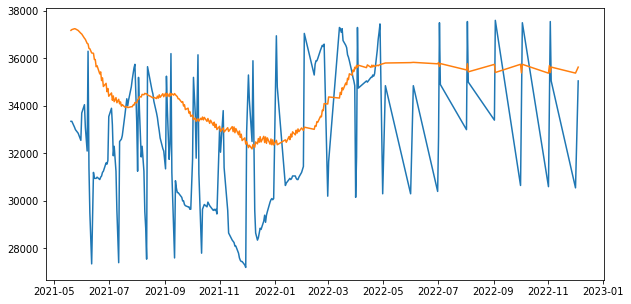

In [55]:
prediction1_a1 = forecast_predict(model1_a, test_beras_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras1_a1 = pd.DataFrame()
data_new_beras1_a1['actual'] = x_test
data_new_beras1_a1['prediction'] = data_result1_a1
data_new_beras1_a1.to_csv('bawang_merah_ukuran_sedang_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a1.actual)
plt.plot(y_test, data_new_beras1_a1.prediction)
data_new_beras1_a1

#### Type 3

In [56]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0270 - mae: 0.1256 - mape: 63.6751 - val_loss: 0.0099 - val_mae: 0.0814 - val_mape: 59.1154
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0270 - mae: 0.1254 - mape: 63.3661 - val_loss: 0.0096 - val_mae: 0.0795 - val_mape: 58.0566
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0269 - mae: 0.1255 - mape: 63.1715 - val_loss: 0.0095 - val_mae: 0.0790 - val_mape: 57.7499
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0269 - mae: 0.1254 - mape: 62.9722 - val_loss: 0.0092 - val_mae: 0.0772 - val_mape: 56.7714
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0269 - mae: 0.1254 - mape: 62.7946 - val_loss: 0.0093 - val_mae: 0.0776 - val_mape: 56.9695
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0269 - mae: 0.1252 - mape: 62.3457 - val_loss: 0.0092 - val_mae: 0.0771 - val_mape: 56.713

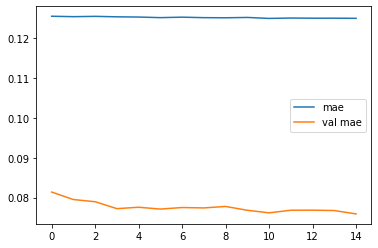

In [57]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2670.6055 8.594534 3126.561050099614


,actual,prediction
0,33350,37142.812500
1,33350,37173.230469
2,33100,37208.992188
3,33000,37198.421875
4,32900,37151.332031
...,...,...
229,34300,35567.117188
230,37550,35261.699219
231,35050,35502.015625
232,30550,35245.683594


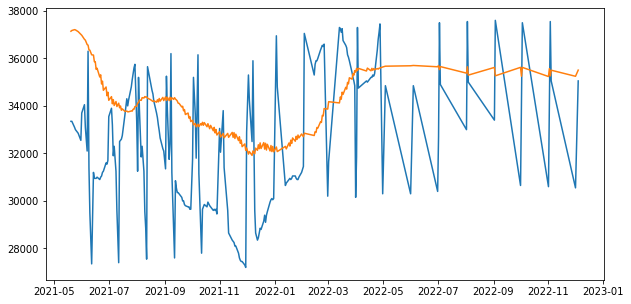

In [58]:
prediction1_a2 = forecast_predict(model1_a, test_beras_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras1_a2 = pd.DataFrame()
data_new_beras1_a2['actual'] = x_test
data_new_beras1_a2['prediction'] = data_result1_a2
data_new_beras1_a2.to_csv('bawang_merah_ukuran_sedang_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a2.actual)
plt.plot(y_test, data_new_beras1_a2.prediction)

data_new_beras1_a2

## model 2

### SGD

In [59]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [60]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [61]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 4s 34ms/step - loss: 0.2449 - mae: 0.4590 - val_loss: 0.0484 - val_mae: 0.2113
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.2447 - mae: 0.4588 - val_loss: 0.0483 - val_mae: 0.2112
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2449 - mae: 0.4589 - val_loss: 0.0483 - val_mae: 0.2111
Epoch 4/100
44/44 [==============================] - 1s 13ms/step - loss: 0.2447 - mae: 0.4586 - val_loss: 0.0483 - val_mae: 0.2110
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2443 - mae: 0.4583 - val_loss: 0.0482 - val_mae: 0.2109
Epoch 6/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2444 - mae: 0.4585 - val_loss: 0.0482 - val_mae: 0.2108
Epoch 7/100
44/44 [==============================] - 1s 15ms/step - loss: 0.2446 - mae: 0.4586 - val_loss: 0.0481 - val_mae: 0.2108
Epoch 8/100
44/44 [==============================] - 1s 14ms/step - loss: 0.

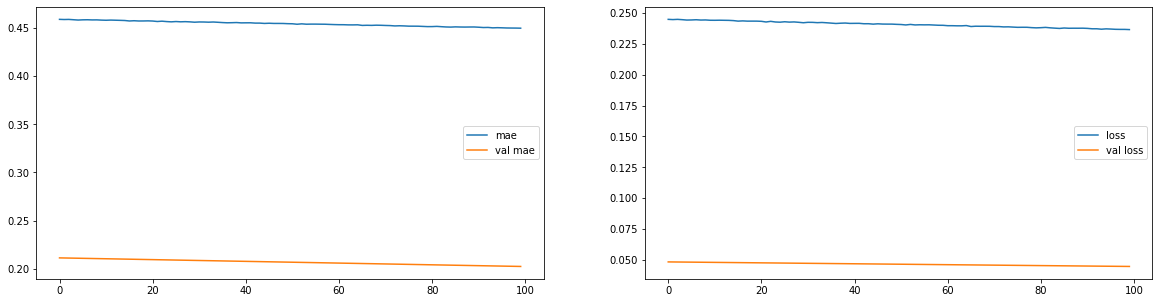

In [62]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
10307.59 31.346071 10679.883145428137


,actual,prediction
0,33350,22138.144531
1,33350,22135.912109
2,33100,22137.705078
3,33000,22142.298828
4,32900,22143.105469
...,...,...
229,34300,22112.337891
230,37550,22104.166016
231,35050,22106.654297
232,30550,22104.460938


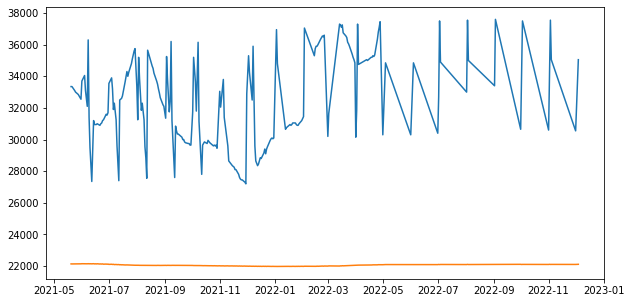

In [63]:
prediction2 = forecast_predict(model2, test_beras_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = x_test
data_new_beras2['prediction'] = data_result2
data_new_beras2.to_csv('bawang_merah_ukuran_sedang_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras2.actual)
plt.plot(y_test, data_new_beras2.prediction)
data_new_beras2

#### Type2

In [64]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1201 - mae: 0.2921 - val_loss: 0.0443 - val_mae: 0.2015
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1196 - mae: 0.2910 - val_loss: 0.0439 - val_mae: 0.2006
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1192 - mae: 0.2903 - val_loss: 0.0436 - val_mae: 0.1996
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1186 - mae: 0.2894 - val_loss: 0.0432 - val_mae: 0.1987
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1181 - mae: 0.2886 - val_loss: 0.0428 - val_mae: 0.1978
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1176 - mae: 0.2877 - val_loss: 0.0425 - val_mae: 0.1969
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1170 - mae: 0.2868 - val_loss: 0.0421 - val_mae: 0.1960
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

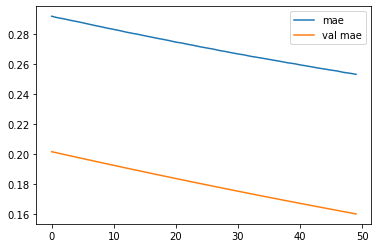

In [65]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [66]:
prediction2_1 = forecast_predict(model2, test_beras_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras2_1 = pd.DataFrame()
data_new_beras2_1['actual'] = x_test
data_new_beras2_1['prediction'] = data_result2_1
data_new_beras2_1.to_csv('bawang_merah_ukuran_sedang_model3_sgd_type2.csv')

data_new_beras2

199/199 [==============================] - 1s 3ms/step
8690.655 26.311749 9128.692787031448


,actual,prediction
0,33350,22138.144531
1,33350,22135.912109
2,33100,22137.705078
3,33000,22142.298828
4,32900,22143.105469
...,...,...
229,34300,22112.337891
230,37550,22104.166016
231,35050,22106.654297
232,30550,22104.460938


#### Type 3

In [67]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1399 - mae: 0.3232 - val_loss: 0.0292 - val_mae: 0.1598
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1399 - mae: 0.3231 - val_loss: 0.0292 - val_mae: 0.1596
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1399 - mae: 0.3230 - val_loss: 0.0292 - val_mae: 0.1595
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1399 - mae: 0.3231 - val_loss: 0.0291 - val_mae: 0.1594
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1397 - mae: 0.3228 - val_loss: 0.0291 - val_mae: 0.1593
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1397 - mae: 0.3228 - val_loss: 0.0291 - val_mae: 0.1592
Epoch 7/50
84/84 [==============================] - 1s 12ms/step - loss: 0.1395 - mae: 0.3226 - val_loss: 0.0290 - val_mae: 0.1590
Epoch 8/50
84/84 [==============================] - 1s 11ms/step - loss: 0.1394 - m

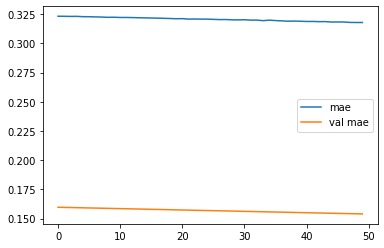

In [68]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [69]:
prediction2_2 = forecast_predict(model2, test_beras_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras2_2 = pd.DataFrame()
data_new_beras2_2['actual'] = x_test
data_new_beras2_2['prediction'] = data_result2_2
data_new_beras2_2.to_csv('bawang_merah_ukuran_sedang_model3_type3.csv')

data_new_beras2_2

181/181 [==============================] - 1s 4ms/step
8443.919 25.544512 8892.806081322138


,actual,prediction
0,33350,24035.425781
1,33350,24044.199219
2,33100,24041.318359
3,33000,24039.841797
4,32900,24038.929688
...,...,...
229,34300,23978.980469
230,37550,23980.425781
231,35050,23985.468750
232,30550,23978.076172


### Adam

In [70]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [71]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 36ms/step - loss: 0.1966 - mae: 0.3974 - val_loss: 0.0172 - val_mae: 0.1212
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0688 - mae: 0.2101 - val_loss: 0.0045 - val_mae: 0.0425
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0387 - mae: 0.1524 - val_loss: 0.0043 - val_mae: 0.0422
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0390 - mae: 0.1522 - val_loss: 0.0045 - val_mae: 0.0429
Epoch 5/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0381 - mae: 0.1485 - val_loss: 0.0050 - val_mae: 0.0458
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0370 - mae: 0.1489 - val_loss: 0.0063 - val_mae: 0.0583
Epoch 7/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0376 - mae: 0.1504 - val_loss: 0.0047 - val_mae: 0.0441
Epoch 8/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0395 - m

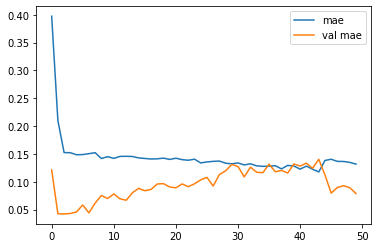

In [72]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [73]:
prediction2_a = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras2_a = pd.DataFrame()
data_new_beras2_a['actual'] = x_test
data_new_beras2_a['prediction'] = data_result2_a
data_new_beras2_a.to_csv('bawang_merah_ukuran_sedang_model3_adam_type1.csv')

data_new_beras2_a

131/131 [==============================] - 1s 6ms/step
4563.152 14.902025 5258.580797135288


,actual,prediction
0,33350,37585.351562
1,33350,37281.617188
2,33100,37258.574219
3,33000,37202.667969
4,32900,37635.046875
...,...,...
229,34300,37805.589844
230,37550,37748.265625
231,35050,37813.542969
232,30550,37787.761719


#### Type 2

In [74]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0234 - mae: 0.1198 - val_loss: 0.0265 - val_mae: 0.1507
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0217 - mae: 0.1156 - val_loss: 0.0116 - val_mae: 0.0896
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0212 - mae: 0.1119 - val_loss: 0.0190 - val_mae: 0.1221
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0212 - mae: 0.1096 - val_loss: 0.0167 - val_mae: 0.1124
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0207 - mae: 0.1103 - val_loss: 0.0128 - val_mae: 0.0956
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0212 - mae: 0.1104 - val_loss: 0.0150 - val_mae: 0.1051
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0208 - mae: 0.1081 - val_loss: 0.0115 - val_mae: 0.0895
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

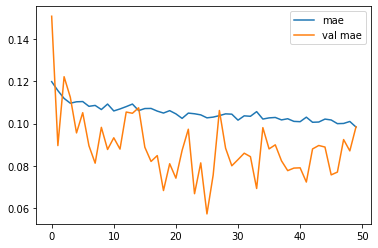

In [75]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
3042.57 9.779264 3549.3826223725164


,actual,prediction
0,33350,39264.390625
1,33350,39110.617188
2,33100,39113.472656
3,33000,39072.078125
4,32900,39308.574219
...,...,...
229,34300,36747.914062
230,37550,36487.785156
231,35050,36718.476562
232,30550,36798.796875


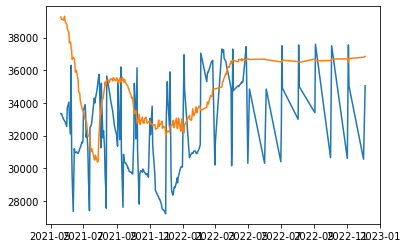

In [76]:
prediction2_a1 = forecast_predict(model2_a, test_beras_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras2_a1 = pd.DataFrame()
data_new_beras2_a1['actual'] = x_test
data_new_beras2_a1['prediction'] = data_result2_a1
data_new_beras2_a1.to_csv('bawang_merah_ukuran_sedang_model3_adam_type2.csv')

plt.plot(y_test, data_new_beras2_a1.actual)
plt.plot(y_test, data_new_beras2_a1.prediction)
data_new_beras2_a1

#### Type 3

In [77]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0235 - mae: 0.1149 - val_loss: 0.0100 - val_mae: 0.0850
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0229 - mae: 0.1113 - val_loss: 0.0091 - val_mae: 0.0805
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0231 - mae: 0.1117 - val_loss: 0.0092 - val_mae: 0.0810
Epoch 4/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0225 - mae: 0.1105 - val_loss: 0.0088 - val_mae: 0.0786
Epoch 5/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0222 - mae: 0.1099 - val_loss: 0.0089 - val_mae: 0.0796
Epoch 6/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0225 - mae: 0.1095 - val_loss: 0.0086 - val_mae: 0.0776
Epoch 7/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0226 - mae: 0.1086 - val_loss: 0.0089 - val_mae: 0.0794
Epoch 8/100
84/84 [==============================] - 1s 11ms/step - loss: 0.

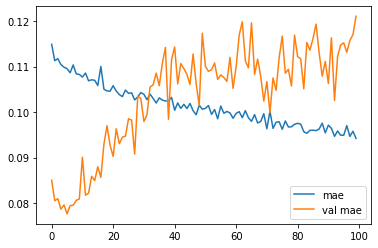

In [78]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 1s 4ms/step
2717.0908 8.5253525 3204.174464663246


,actual,prediction
0,33350,36051.843750
1,33350,36411.523438
2,33100,36306.300781
3,33000,35208.558594
4,32900,36738.238281
...,...,...
229,34300,36189.183594
230,37550,36483.687500
231,35050,36194.597656
232,30550,35855.078125


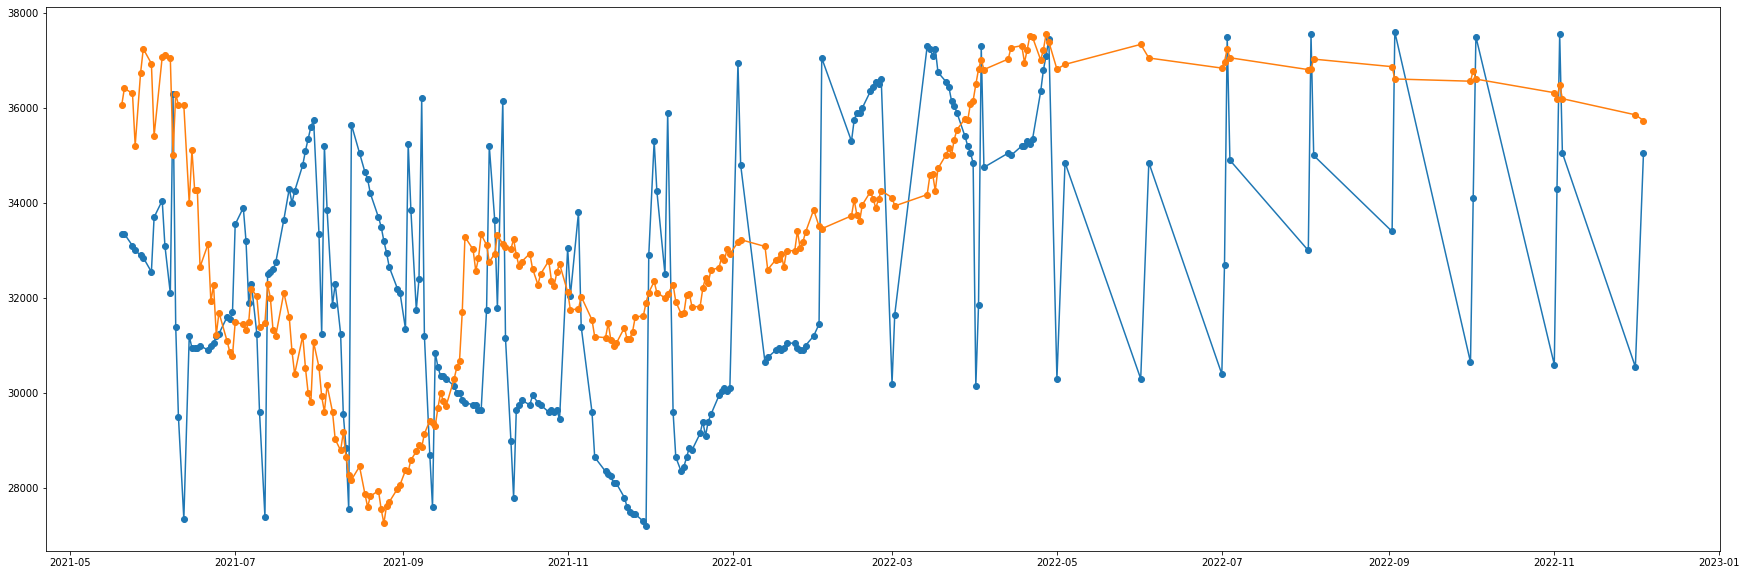

In [79]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras2_a2 = pd.DataFrame()
data_new_beras2_a2['actual'] = x_test
data_new_beras2_a2['prediction'] = data_result2_a2
data_new_beras2_a2.to_csv('bawang_merah_ukuran_sedang_model3_adam_type3.csv')
plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras2_a2.actual, '-o')
plt.plot(y_test,data_new_beras2_a2.prediction, '-o')
data_new_beras2_a2